In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

BATCH_SIZE = 4
EPOCHS = 10
data_dir = "/home/iai/Desktop/Jeewon/Seminar/20230112_MVtecAD/data/dataset_auto"

cuda


In [41]:
transform = transforms.Compose(
    [
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

train_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
print(train_dataset.classes)
print("size of train dataset : ", len(train_dataset))
print(train_dataset[0][0].shape)

test_dataset = ImageFolder(os.path.join(data_dir, 'test'), transform)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, num_workers = 2)
print(test_dataset.classes)
print("size of test dataset : ", len(test_dataset))

['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
size of train dataset :  3629
torch.Size([3, 224, 224])
['bottle_broken_large', 'bottle_broken_small', 'bottle_contamination', 'bottle_good', 'cable_bent_wire', 'cable_combined', 'cable_cut_inner_insulation', 'cable_cut_outer_insulation', 'cable_good', 'cable_missing_cable', 'cable_missing_wire', 'cable_poke_insulation', 'cable_swap', 'capsule_crack', 'capsule_faulty_imprint', 'capsule_good', 'capsule_poke', 'capsule_scratch', 'capsule_squeeze', 'carpet_color', 'carpet_cut', 'carpet_good', 'carpet_hole', 'carpet_metal_contamination', 'carpet_thread', 'grid_bent', 'grid_broken', 'grid_glue', 'grid_good', 'grid_metal_contamination', 'grid_thread', 'hazelnut_crack', 'hazelnut_cut', 'hazelnut_good', 'hazelnut_hole', 'hazelnut_print', 'leather_color', 'leather_cut', 'leather_fold', 'leather_glue', 'leather_good', 'leather_poke', 'metal_n

In [42]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.8439) tensor(2.6400)
torch.Size([4, 3, 224, 224])
torch.float32


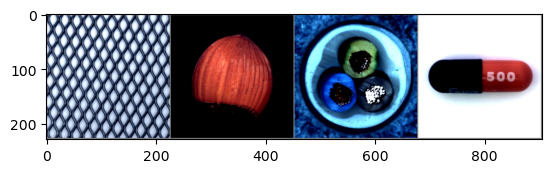

torch.Size([4, 3, 224, 224])


In [43]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

print(images.shape)
print(images.dtype)

imshow(torchvision.utils.make_grid(images))
print(images.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.6042) tensor(2.6400)


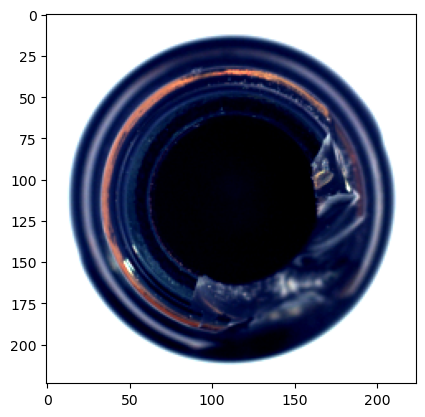

torch.Size([1, 3, 224, 224])


In [44]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

imshow(torchvision.utils.make_grid(images))
print(images.shape)

In [45]:
# CNN Autoencoder

class CNN_Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    # N, 3, 224, 224
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 16, 4, stride = 2, padding = 1), # N, 16, 112, 112
        nn.ReLU(),
        nn.Conv2d(16, 32, 4, stride = 2, padding = 1), # N, 32, 56, 56
        nn.ReLU(),
        nn.Conv2d(32, 64, 4, stride = 2, padding = 1), # N, 64, 28, 28
        nn.ReLU(),
        nn.Conv2d(64, 128, 4, stride = 2, padding = 1), # N, 128, 14, 14
        nn.ReLU(),
        nn.Conv2d(128, 256, 14) # N, 256, 1, 1
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(256, 128, 14),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, 4, stride = 2, padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride = 2, padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 4, stride = 2, padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 3, 4, stride = 2, padding = 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [46]:
model = CNN_Autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [47]:
output_train = []
train_loss = []

for epoch in range(EPOCHS):
  for (img, _) in train_loader:
    # img = img.reshape(-1, 224*224*3)
    img = img.to(device)
    recon = model(img)
    loss = criterion(recon, img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

  print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
  output_train.append((epoch, img, recon))

Epoch:1, Loss:0.6478
Epoch:2, Loss:0.6413
Epoch:3, Loss:0.0974
Epoch:4, Loss:0.4991
Epoch:5, Loss:1.3399
Epoch:6, Loss:0.0774
Epoch:7, Loss:1.8014
Epoch:8, Loss:0.4188
Epoch:9, Loss:0.5487
Epoch:10, Loss:0.4200


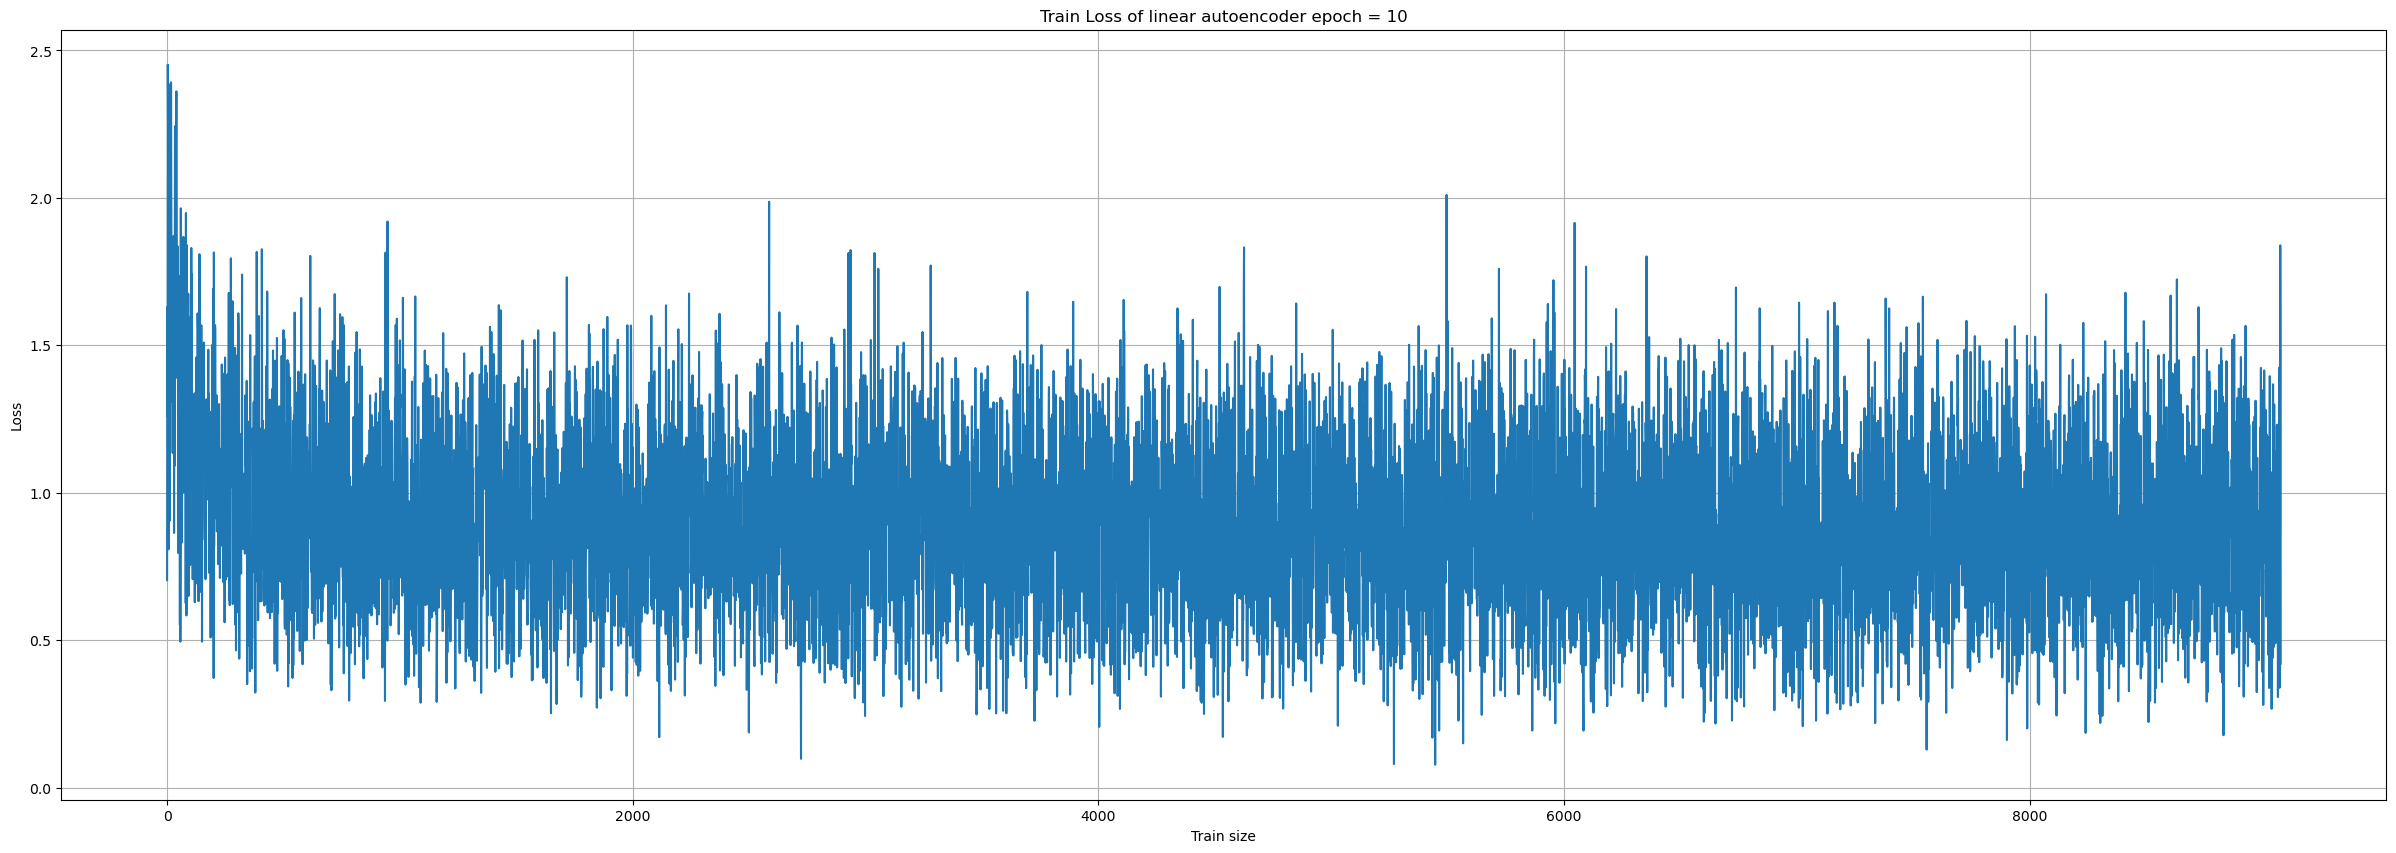

In [48]:
plt.figure(figsize=(30,10))
plt.plot(train_loss)
plt.grid()
plt.xlabel('Train size')
plt.ylabel('Loss')
plt.title('Train Loss of linear autoencoder epoch = 10')
plt.legend
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


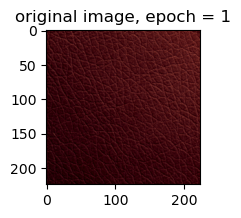

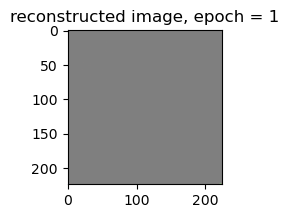

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


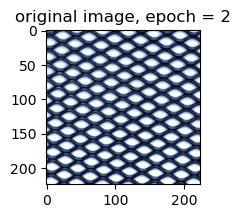

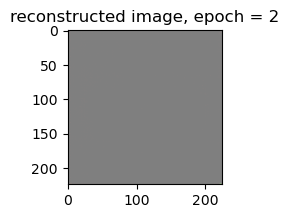

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


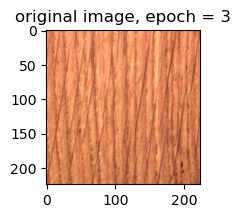

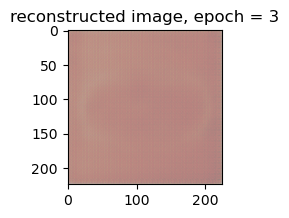

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


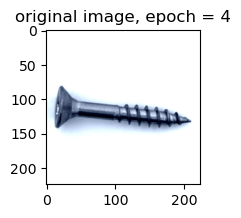

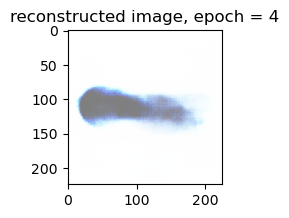

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


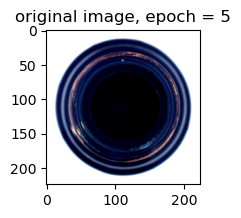

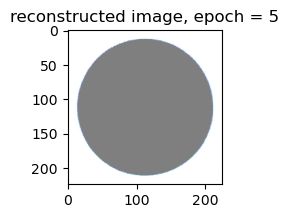

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


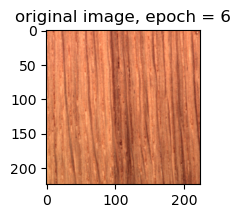

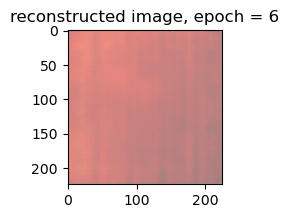

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


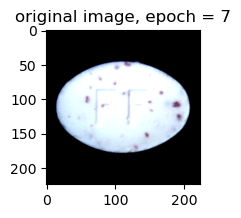

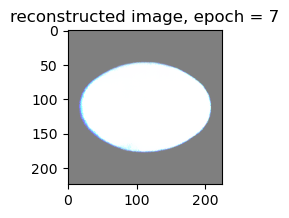

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


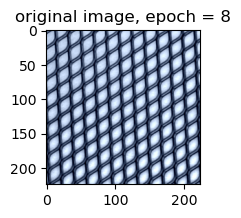

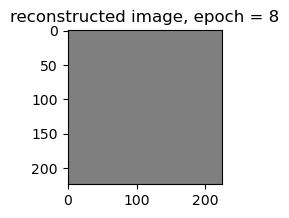

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


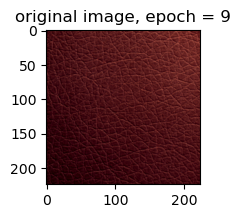

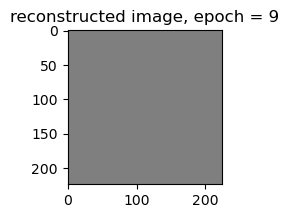

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


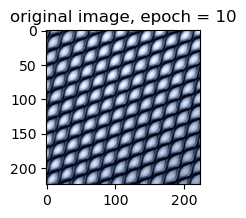

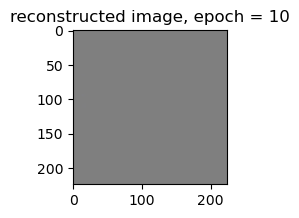

In [49]:
for k in range(0, EPOCHS):
    plt.figure(figsize=(10, 2))
    plt.title("original image, epoch = {}".format(k+1))
    imgs = output_train[k][1].cpu()
    recon = output_train[k][2].detach().cpu()
    for i, item in enumerate(imgs):
        item = item.reshape(3,224,224) # -> use for Autoencoder_Linear
        imshow(item)
    plt.figure(figsize=(10, 2))  
    plt.title("reconstructed image, epoch = {}".format(k+1))      
    for i, item in enumerate(recon):
        item = item.reshape(3, 224,224) # -> use for Autoencoder_Linear
        imshow(item)

In [50]:
test_loss = []
output_test = []

with torch.no_grad():
  for (img, _) in test_loader:
    # img = img.reshape(-1, 224*224*3)
    img = img.to(device)
    recon = model(img)
    loss = criterion(recon, img)
    test_loss.append(loss.item())
    
  print(f'Loss:{loss.item():.4f}')
  output_test.append((epoch, img, recon))

Loss:1.3497


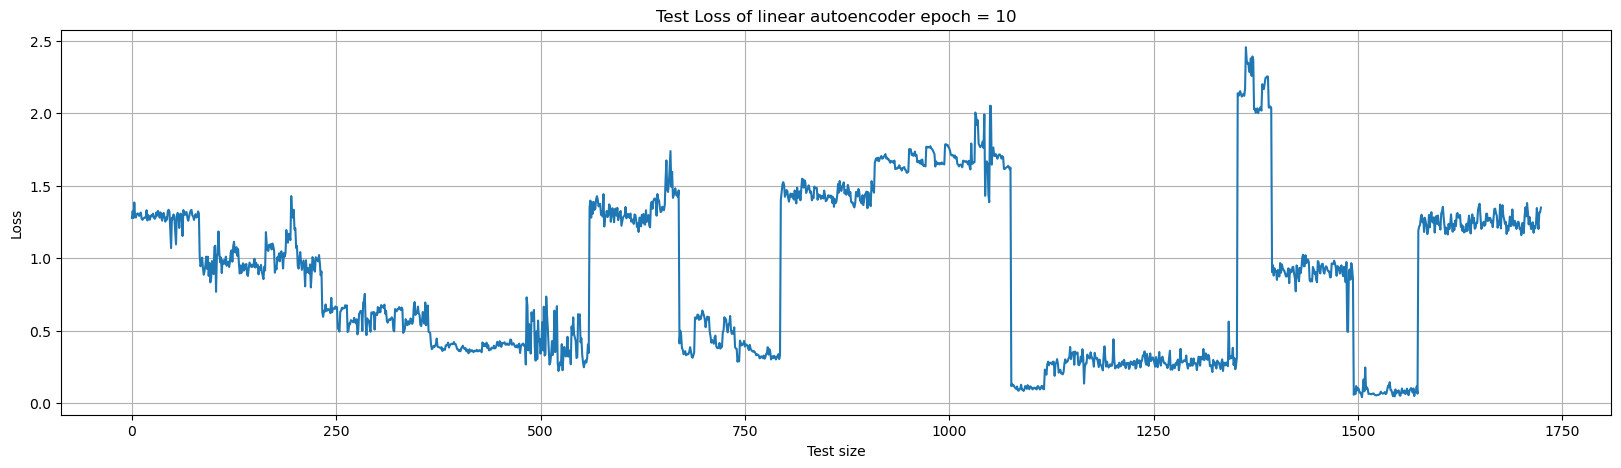

In [51]:
plt.figure(figsize=(20,5))
plt.plot(test_loss)
plt.grid()
plt.xlabel('Test size')
plt.ylabel('Loss')
plt.title('Test Loss of linear autoencoder epoch = 10')
plt.legend
plt.show()

In [52]:
print(len(test_loss))

1725


In [53]:
import pandas as pd

label_list = []

df_trainloss = pd.DataFrame({'train_loss':train_loss,'label':'good'})

dict = test_dataset.class_to_idx

dataiter = iter(test_loader)
for i in range(len(test_loader)):
    _, labels = next(dataiter)
    label_list.append(labels.numpy())

df_testloss = pd.DataFrame({'test_loss':test_loss,'label':label_list, 'True':None, 'Predicted':None})
df_testloss['label'] = df_testloss['label'].astype('int32')

In [54]:
def findKey(value):
    key = {v:k for k,v in dict.items()}
    return key.get(value)

for i in range(len(test_loss)):
    df_testloss['label'][i] = findKey(df_testloss['label'][i])

/tmp/ipykernel_3326567/3444478992.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['label'][i] = findKey(df_testloss['label'][i])


In [55]:
df_testloss

,test_loss,label,True,Predicted
0,1.278530,bottle_broken_large,None,None
1,1.325068,bottle_broken_large,None,None
2,1.277374,bottle_broken_large,None,None
3,1.385061,bottle_broken_large,None,None
4,1.283803,bottle_broken_large,None,None
...,...,...,...,...
1720,1.256877,zipper_squeezed_teeth,None,None
1721,1.202225,zipper_squeezed_teeth,None,None
1722,1.316437,zipper_squeezed_teeth,None,None
1723,1.317563,zipper_squeezed_teeth,None,None


In [56]:
for i in range(len(test_loss)):
    if 'good' in df_testloss['label'][i]:
        # print(i)
        df_testloss['True'][i] = 'normal'
    else:
        df_testloss['True'][i] = 'anomaly'

df_testloss.head(70)

/tmp/ipykernel_3326567/676495749.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['True'][i] = 'anomaly'
/tmp/ipykernel_3326567/676495749.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['True'][i] = 'normal'


,test_loss,label,True,Predicted
0,1.278530,bottle_broken_large,anomaly,None
1,1.325068,bottle_broken_large,anomaly,None
2,1.277374,bottle_broken_large,anomaly,None
3,1.385061,bottle_broken_large,anomaly,None
4,1.283803,bottle_broken_large,anomaly,None
...,...,...,...,...
65,1.299154,bottle_good,normal,None
66,1.317661,bottle_good,normal,None
67,1.318081,bottle_good,normal,None
68,1.277193,bottle_good,normal,None


In [57]:
print("Length of test loss : {}".format(len(test_loss)))

Length of test loss : 1725


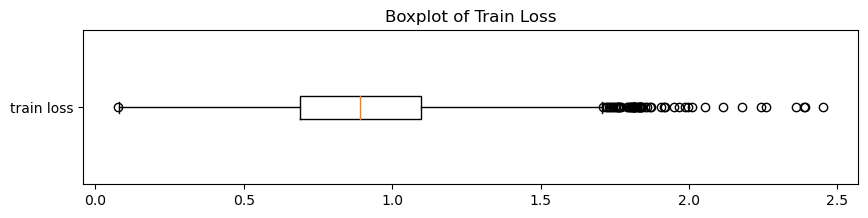

        train_loss
count  9080.000000
mean      0.902122
std       0.294925
min       0.077404
25%       0.689442
50%       0.890090
75%       1.096949
max       2.451588
Length of train loss : 9080
Frequency of loss more than 3QR : train_loss    2270
label         2270
dtype: int64


In [58]:
plt.figure(figsize=(10,2))
plt.boxplot(df_trainloss['train_loss'], vert = 0)
plt.title("Boxplot of Train Loss")
plt.yticks([1],["train loss"])
plt.show()

print(df_trainloss.describe())
trainloss_75 = np.percentile(df_trainloss['train_loss'], 75)
trainloss_25 = np.percentile(df_trainloss['train_loss'], 25)

print("Length of train loss : {}".format(len(train_loss)))
print("Frequency of loss more than 3QR : {}".format(df_trainloss[(df_trainloss['train_loss'] > trainloss_75)].count()))

In [59]:
print("Length of test : {}".format(len(test_loss)))

Length of test : 1725


In [60]:
threshold = np.percentile(df_trainloss['train_loss'], 75)
threshold

1.0969487130641937

In [61]:
for i in range(len(test_loss)):
    if df_testloss['test_loss'][i]>threshold:
        df_testloss['Predicted'][i] = 'anomaly'
    else:
        df_testloss['Predicted'][i] = 'normal'

df_testloss

/tmp/ipykernel_3326567/1336415062.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'anomaly'
/tmp/ipykernel_3326567/1336415062.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'normal'


,test_loss,label,True,Predicted
0,1.278530,bottle_broken_large,anomaly,anomaly
1,1.325068,bottle_broken_large,anomaly,anomaly
2,1.277374,bottle_broken_large,anomaly,anomaly
3,1.385061,bottle_broken_large,anomaly,anomaly
4,1.283803,bottle_broken_large,anomaly,anomaly
...,...,...,...,...
1720,1.256877,zipper_squeezed_teeth,anomaly,anomaly
1721,1.202225,zipper_squeezed_teeth,anomaly,anomaly
1722,1.316437,zipper_squeezed_teeth,anomaly,anomaly
1723,1.317563,zipper_squeezed_teeth,anomaly,anomaly


In [62]:
print(df_testloss['True'].value_counts())
print(df_testloss['Predicted'].value_counts())

anomaly    1258
normal      467
Name: True, dtype: int64
normal     1042
anomaly     683
Name: Predicted, dtype: int64


In [63]:
TP = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'anomaly')].count()
TP = TP[0]

FN = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'normal')].count()
FN = FN[0]

FP = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'anomaly')].count()
FP = FP[0]

TN = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'normal')].count()
TN = TN[0]

In [64]:
accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP / (TP+FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy is {}".format(accuracy))
print("Precision is {}".format(precision))
print("Recall is {}".format(recall))
print("F1 score is {}".format(f1_score))

Accuracy is 0.48695652173913045
Precision is 0.7730600292825769
Recall is 0.41971383147853736
F1 score is 0.5440494590417311


In [65]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(df_testloss['True'], df_testloss['Predicted'])
cf

array([[528, 730],
       [155, 312]])

Text(0.5, 1.0, 'Confusion Matrix')

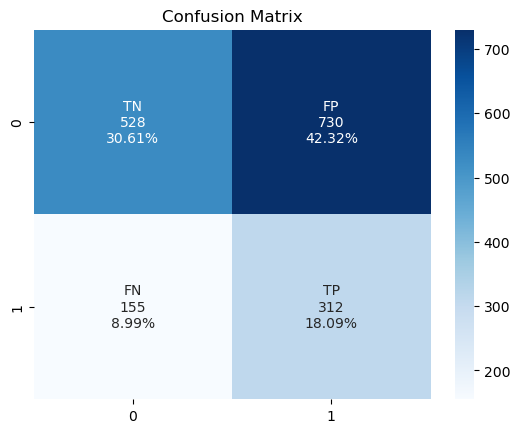

In [66]:
import seaborn as sns

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion Matrix")

Accuracy is 0.48695652173913045
Precision is 0.7121729237770194
Recall is 0.49761526232114467
F1 score is 0.5858680393074404
[[626 632]
 [253 214]]


/tmp/ipykernel_3326567/3748311953.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'anomaly'
/tmp/ipykernel_3326567/3748311953.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'normal'


Text(0.5, 1.0, 'Confusion Matrix')

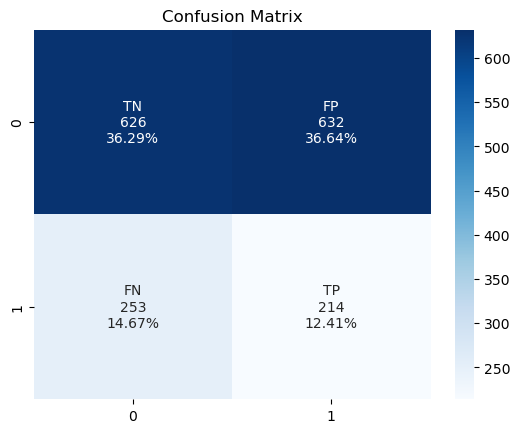

In [67]:
# threshold = 50

threshold = np.percentile(df_trainloss['train_loss'], 50)

for i in range(len(test_loss)):
    if df_testloss['test_loss'][i]>threshold:
        df_testloss['Predicted'][i] = 'anomaly'
    else:
        df_testloss['Predicted'][i] = 'normal'

TP = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'anomaly')].count()
TP = TP[0]

FN = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'normal')].count()
FN = FN[0]

FP = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'anomaly')].count()
FP = FP[0]

TN = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'normal')].count()
TN = TN[0]

accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP / (TP+FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy is {}".format(accuracy))
print("Precision is {}".format(precision))
print("Recall is {}".format(recall))
print("F1 score is {}".format(f1_score))

cf = confusion_matrix(df_testloss['True'], df_testloss['Predicted'])
print(cf)

import seaborn as sns

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion Matrix")

/tmp/ipykernel_3326567/420772052.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'anomaly'
/tmp/ipykernel_3326567/420772052.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'normal'


Accuracy is 0.48985507246376814
Precision is 0.7045454545454546
Recall is 0.5174880763116058
F1 score is 0.5967002749770853
[[651 607]
 [273 194]]


Text(0.5, 1.0, 'Confusion Matrix')

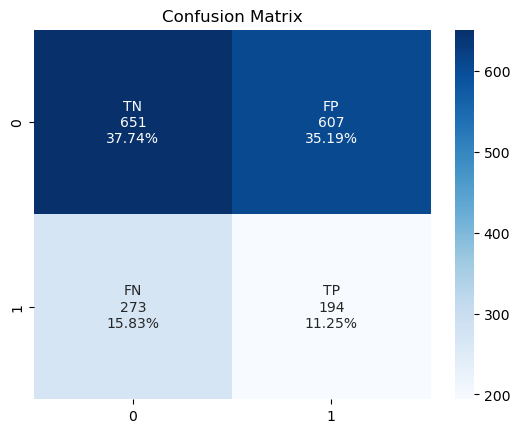

In [68]:
# threshold = 25

threshold = np.percentile(df_trainloss['train_loss'], 25)

for i in range(len(test_loss)):
    if df_testloss['test_loss'][i]>threshold:
        df_testloss['Predicted'][i] = 'anomaly'
    else:
        df_testloss['Predicted'][i] = 'normal'

TP = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'anomaly')].count()
TP = TP[0]

FN = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'normal')].count()
FN = FN[0]

FP = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'anomaly')].count()
FP = FP[0]

TN = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'normal')].count()
TN = TN[0]

accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP / (TP+FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy is {}".format(accuracy))
print("Precision is {}".format(precision))
print("Recall is {}".format(recall))
print("F1 score is {}".format(f1_score))

cf = confusion_matrix(df_testloss['True'], df_testloss['Predicted'])
print(cf)

import seaborn as sns

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion Matrix")

/tmp/ipykernel_3326567/141051450.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'anomaly'
/tmp/ipykernel_3326567/141051450.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'normal'


Accuracy is 0.487536231884058
Precision is 0.7169373549883991
Recall is 0.4912559618441971
F1 score is 0.5830188679245283
[[618 640]
 [244 223]]


Text(0.5, 1.0, 'Confusion Matrix')

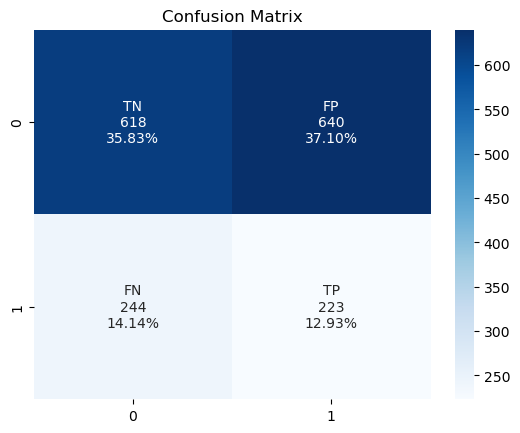

In [69]:
# threshold = avg of train loss

threshold = df_trainloss['train_loss'].mean()

for i in range(len(test_loss)):
    if df_testloss['test_loss'][i]>threshold:
        df_testloss['Predicted'][i] = 'anomaly'
    else:
        df_testloss['Predicted'][i] = 'normal'

TP = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'anomaly')].count()
TP = TP[0]

FN = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'normal')].count()
FN = FN[0]

FP = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'anomaly')].count()
FP = FP[0]

TN = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'normal')].count()
TN = TN[0]

accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP / (TP+FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy is {}".format(accuracy))
print("Precision is {}".format(precision))
print("Recall is {}".format(recall))
print("F1 score is {}".format(f1_score))

cf = confusion_matrix(df_testloss['True'], df_testloss['Predicted'])
print(cf)

import seaborn as sns

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion Matrix")

/tmp/ipykernel_3326567/3055069119.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'anomaly'
/tmp/ipykernel_3326567/3055069119.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'normal'


Accuracy is 0.4863768115942029
Precision is 0.7089887640449438
Recall is 0.5015898251192369
F1 score is 0.5875232774674115
[[631 627]
 [259 208]]


Text(0.5, 1.0, 'Confusion Matrix')

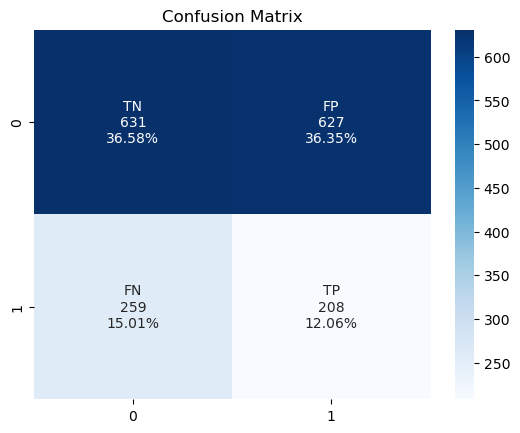

: 

In [70]:
# threshold = avg of test loss

threshold = df_testloss['test_loss'].mean()

for i in range(len(test_loss)):
    if df_testloss['test_loss'][i]>threshold:
        df_testloss['Predicted'][i] = 'anomaly'
    else:
        df_testloss['Predicted'][i] = 'normal'

TP = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'anomaly')].count()
TP = TP[0]

FN = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'normal')].count()
FN = FN[0]

FP = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'anomaly')].count()
FP = FP[0]

TN = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'normal')].count()
TN = TN[0]

accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP / (TP+FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy is {}".format(accuracy))
print("Precision is {}".format(precision))
print("Recall is {}".format(recall))
print("F1 score is {}".format(f1_score))

cf = confusion_matrix(df_testloss['True'], df_testloss['Predicted'])
print(cf)

import seaborn as sns

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion Matrix")